In [ ]:
#--------------------------

In [5]:
!pip install  openimages torch_snippets urllib3

Defaulting to user installation because normal site-packages is not writeable


In [11]:
!wget  open_images_train_captions.json https://storage.googleapis.com/localized-narratives/annotations/open_images_train_v6_captions.json

--2024-07-11 18:48:16--  http://open_images_train_captions.json/
Resolving open_images_train_captions.json (open_images_train_captions.json)... failed: Name or service not known.
wget: unable to resolve host address ‘open_images_train_captions.json’
--2024-07-11 18:48:16--  https://storage.googleapis.com/localized-narratives/annotations/open_images_train_v6_captions.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.150.207, 173.194.73.207, 209.85.233.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.150.207|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-07-11 18:48:17 ERROR 404: Not Found.



In [1]:
#!pip install -qU openimages torch_snippets urllib3
#!wget -O open_images_train_captions.jsonl -q https://storage.googleapis.com/localized-narratives/annotations/open_images_train_v6_captions.jsonl
from torch_snippets import *
import json
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
from tqdm import tqdm

In [27]:
with open('open_images_train_captions.jsonl', 'r') as json_file:
    json_list = json_file.read().split('\n')
print(1)
np.random.shuffle(json_list)
data = []
N = 1000

   
for ix, json_str in Tqdm(enumerate(json_list), N):
    if ix == N: break
    try:
          
        result = json.loads(json_str)
        x = pd.DataFrame.from_dict(result, orient='index').T
          
        data.append(x)
    except:
        pass
     

1


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1228.44it/s]


In [28]:
len(data)

1000

In [29]:
np.random.seed(10)
data = pd.concat(data)
data['train'] = np.random.choice([True, False], size = len(data), p = [0.95, 0.05])
data.to_csv('data.csv', index = False)

In [30]:
from openimages.download import _download_images_by_id

In [31]:
!mkdir train-images val-images

mkdir: cannot create directory ‘train-images’: File exists
mkdir: cannot create directory ‘val-images’: File exists


In [32]:
subset_imageIds = data[data['train']].image_id.tolist()
_download_images_by_id(subset_imageIds, 'train', './train-images/')
subset_imageIds = data[~data['train']].image_id.tolist()
_download_images_by_id(subset_imageIds, 'train', './val-images/')

100%|███████████████████████████████████████████| 44/44 [00:02<00:00, 15.51it/s]


In [33]:
from torchtext.data import Field
from pycocotools.coco import COCO
from collections import defaultdict

captions = Field(sequential=False, init_token='', eos_token='')
all_captions = data[data['train']]['caption'].tolist()
all_tokens = [[w.lower() for w in c.split()] for c in all_captions]
all_tokens = [w for sublist in all_tokens for w in sublist]
captions.build_vocab(all_tokens)
     

class Vocab: pass
vocab = Vocab()
captions.vocab.itos.insert(0, '')
vocab.itos = captions.vocab.itos

vocab.stoi = defaultdict(lambda: captions.vocab.itos.index(''))
vocab.stoi[''] = 0
for s,i in captions.vocab.stoi.items():
    vocab.stoi[s] = i+1

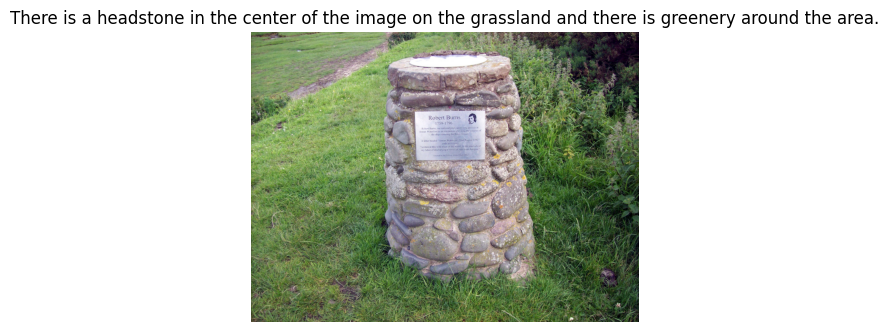

tensor([   2,    7,    8,    4, 1386,    5,    3,   57,   15,    3,   16,   11,
           3,  849,    6,    7,    8,  517,  204,    3, 1055,    2])


In [34]:
from torchvision import transforms
class CaptioningData(Dataset):
    def __init__(self, root, df, vocab):
        self.df = df.reset_index(drop=True)
        self.root = root
        self.vocab = vocab
        self.transform = transforms.Compose([ 
            transforms.Resize(224),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(), 
            transforms.ToTensor(), 
            transforms.Normalize((0.485, 0.456, 0.406), 
                                 (0.229, 0.224, 0.225))]
        )
    def __getitem__(self, index):
        row = self.df.iloc[index].squeeze()
        id = row.image_id
        image_path = f'{self.root}/{id}.jpg'
        image = Image.open(os.path.join(image_path)).convert('RGB')

        caption = row.caption
        tokens = str(caption).lower().split()
        target = []
        target.append(vocab.stoi[''])
        target.extend([vocab.stoi[token] for token in tokens])
        target.append(vocab.stoi[''])
        target = torch.Tensor(target).long()
        return image, target, caption
    def choose(self):
        return self[np.random.randint(len(self))]
    def __len__(self):
        return len(self.df)
    def collate_fn(self, data):
        data.sort(key=lambda x: len(x[1]), reverse=True)
        images, targets, captions = zip(*data)
        images = torch.stack([self.transform(image) for image in images], 0)
        lengths = [len(tar) for tar in targets]
        _targets = torch.zeros(len(captions), max(lengths)).long()
        for i, tar in enumerate(targets):
            end = lengths[i]
            _targets[i, :end] = tar[:end] 
        return images.to(device), _targets.to(device), torch.tensor(lengths).long().to(device)
trn_ds = CaptioningData('train-images', data[data['train']], vocab)
val_ds = CaptioningData('val-images', data[~data['train']], vocab)

image, target, caption = trn_ds.choose()
show(image, title=caption, sz=5); print(target)

In [35]:
trn_dl = DataLoader(trn_ds, 32, collate_fn = trn_ds.collate_fn, drop_last = True)
val_dl = DataLoader(val_ds, 32, collate_fn = val_ds.collate_fn, drop_last = True)

In [36]:
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import models

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained = True)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size//2)
        self.bn = nn.BatchNorm1d(embed_size//2, momentum = 0.01)
        self.linear2 = nn.Bilinear(embed_size//2,embed_size//2, embed_size) #!
        self.ln = nn.LayerNorm(embed_size, eps=1e-05) #!
        
    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1) #perevodim v 2 razmernosti
        features = self.bn(self.linear(features))
        
        features = self.ln(self.linear2(features, features)) #!
        return features

encoder = EncoderCNN(256).to(device)
!pip install torch_summary
from torchsummary import summary
print(summary(encoder, torch.zeros(32,3,224,224).to(device)))
        
        

Defaulting to user installation because normal site-packages is not writeable
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2048, 1, 1]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 256, 56, 56]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 56, 56]         75,008
|    |    └─Bottleneck: 3-2              [-1, 256, 56, 56]         70,400
|    |    └─Bottleneck: 3-3              [-1, 256, 56, 56]         70,400
|    └─Sequential: 2-6                   [-1, 512, 28, 28]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 28, 28]         379,392
|    |    └─Bottleneck: 3-5              [-1, 512, 28, 2

In [37]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=50):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout = 0.02)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths.cpu(), batch_first=True) 
        outputs, _ = self.lstm(packed)
        outputs = self.linear(outputs[0])
        return outputs
    
    def predict(self, features, states=None):
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.lstm(inputs, states) 
            outputs = self.linear(hiddens.squeeze(1)) 
            _, predicted = outputs.max(1) 
            sampled_ids.append(predicted)
            inputs = self.embed(predicted) 
            inputs = inputs.unsqueeze(1) 

        sampled_ids = torch.stack(sampled_ids, 1) 
        
        sentences = []
        for sampled_id in sampled_ids:
            sampled_id = sampled_id.cpu().numpy()
            sampled_caption = []
            for word_id in sampled_id:
                word = vocab.itos[word_id]
                sampled_caption.append(word)
                if word == '':
                    break
            sentence = ' '.join(sampled_caption)
            sentences.append(sentence)
        return sentences

In [43]:
def train_batch(data, encoder, decoder, optimizer, criterion):
    encoder.train()
    decoder.train()
    images, captions, lengths = data
    images = images.to(device)
    captions = captions.to(device)
    targets = pack_padded_sequence(captions, lengths.cpu(), batch_first=True)[0]
    features = encoder(images)
    outputs = decoder(features, captions, lengths)
    loss = criterion(outputs, targets)
    decoder.zero_grad()
    encoder.zero_grad()
    loss.backward()
    optimizer.step()
    return loss
     

@torch.no_grad()
def validate_batch(data, encoder, decoder, criterion):
    encoder.eval()
    decoder.eval()
    images, captions, lengths = data
    images = images.to(device)
    captions = captions.to(device)
    targets = pack_padded_sequence(captions, lengths.cpu(), batch_first=True)[0]
    features = encoder(images)
    outputs = decoder(features, captions, lengths)
    loss = criterion(outputs, targets)
    return loss

EPOCH: 1.000  trn_loss: 5.058  val_loss: nan  (45.58s - 91.16s remaining)
EPOCH: 2.000  trn_loss: 3.496  val_loss: 3.781  (91.09s - 45.54s remaining)
EPOCH: 3.000  trn_loss: 3.197  val_loss: 3.285  (136.80s - 0.00s remaining)


100%|██████████████████████████████████████| 104/104 [00:00<00:00, 39749.19it/s]


[07/12/24 00:40:42] INFO     metric val_loss was not fully recorded. Plotting final epochs using last recorded value                         ]8;id=702165;file:///home/lera/.local/lib/python3.10/site-packages/torch_snippets/torch_loader.py:733\torch_loader.py]8;;\:]8;id=842944;file:///home/lera/.local/lib/python3.10/site-packages/torch_snippets/torch_loader.py:733#plot_epochs:733\plot_epochs:733]8;;\

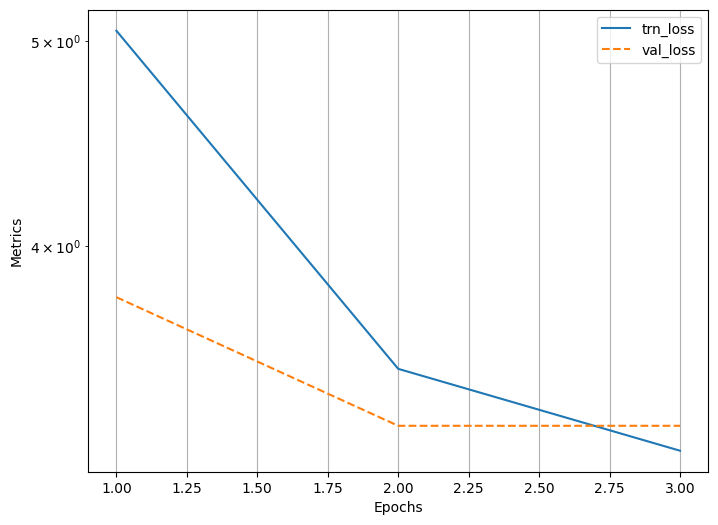

In [44]:
encoder = EncoderCNN(256).to(device)
decoder = DecoderRNN(256, 512, len(vocab.itos), 1).to(device)
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.AdamW(params, lr=1e-3)
n_epochs = 3
log = Report(n_epochs)
     

for epoch in range(n_epochs):
    if epoch == 2: optimizer = torch.optim.AdamW(params, lr=1e-4)
    N = len(trn_dl)
    for i, data in enumerate(trn_dl):
        trn_loss = train_batch(data, encoder, decoder, optimizer, criterion)
        pos = epoch + (1+i)/N
        log.record(pos=pos, trn_loss=trn_loss, end='\r')

    N = len(val_dl)
    for i, data in enumerate(val_dl):
        val_loss = validate_batch(data, encoder, decoder, criterion)
        pos = epoch + (1+i)/N
        log.record(pos=pos, val_loss=val_loss, end='\r')

    log.report_avgs(epoch+1)

log.plot_epochs(log=True)
     

In [46]:
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    if transform is not None:
        tfm_image = transform(image)[None]
    return image, tfm_image

@torch.no_grad()
def load_image_and_predict(image_path):
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))
    ])

    org_image, tfm_image = load_image(image_path, transform)
    image_tensor = tfm_image.to(device)
    encoder.eval()
    decoder.eval()
    feature = encoder(image_tensor)
    sentence = decoder.predict(feature)[0]
    show(org_image, title=sentence)
    return sentence



In [ ]:
# чтобы увеличить точность и уменьшить loss, надо увеличить обьем взятых данных и количество эпох